# Preliminary analysis for large aspect-ratio

We have datasets corresponding to variation in the following parameters of the ligament ensemble
- Two levels of initial perturbation strength : $\varepsilon = \{0.038, 0.076\}$
- Aspect-ratio, defined with respect to initial ligament width : $\Lambda = 100$

We start by loading the required libraries, and set the plotting styles. Check if working


In [1]:
from IPython.core.interactiveshell import InteractiveShell

# pretty print all cell's output and not just the last one
InteractiveShell.ast_node_interactivity = "all"

# Required libraries for data arrays, data manipulation, plotting etc
import numpy as np
import pandas as pd

import seaborn as sns
sns.set_context("poster")
sns.set(rc={'figure.figsize': (16, 9.)})
sns.set_style("whitegrid")

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['text.latex.preamble']=[r"\usepackage{lmodern}",r'\boldmath']


#sns.set(style="white", palette="muted")
#sns.set_context("paper")


## Individual ligaments - example
This is an example of the images generated from the simulation of an individual ligament.

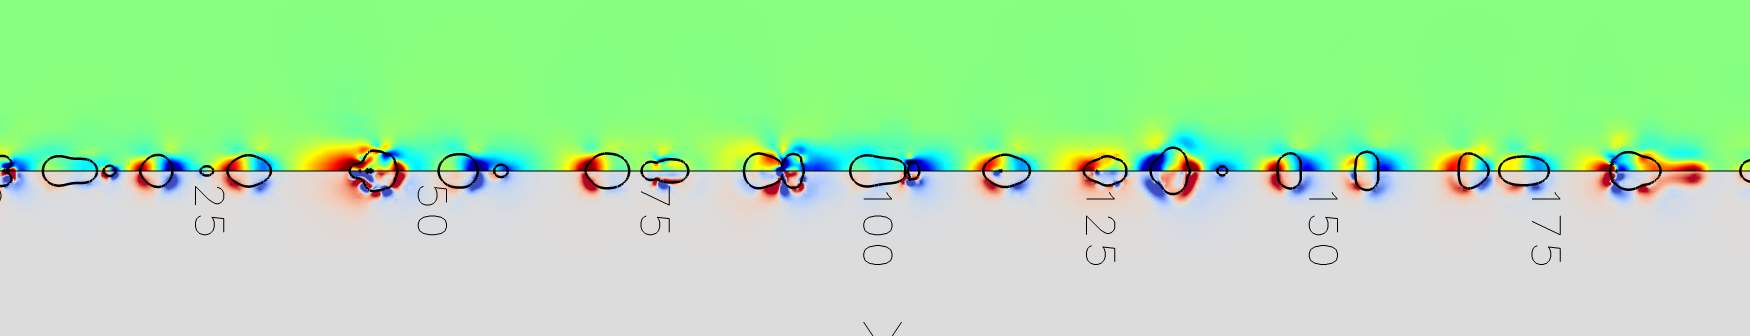

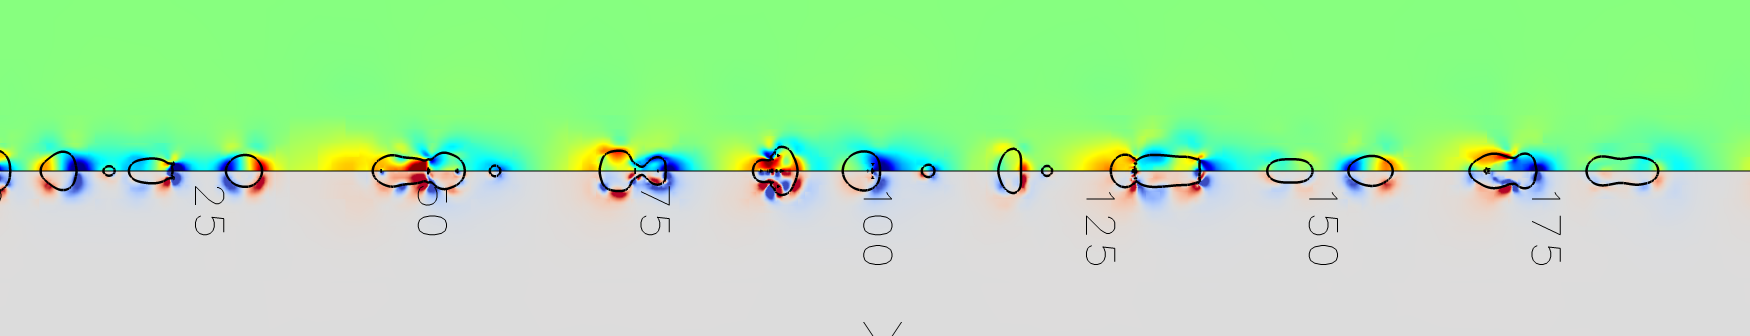

In [20]:
from IPython.display import Image, display

listOfImageNames = ['../d2/img-snapshot-18.png',
                    '../d4/img-snapshot-18.png']

for imageName in listOfImageNames:
    display(Image(filename=imageName))

Both images are saved at $T=18$, where the top image corresponds to the weaker initial perturbation. 

## Data manipulation
Now we load the big dataset. 

In [3]:
big_1 = pd.read_csv("../results", sep=" ")
big_1.head()

Ohnesorge  aspect-ratio  cut-off  amplitude  time  tag  position  velocity  \
0       0.01            50      0.5        0.1     0    1   49.4770  0.000000   
1       0.01            50      0.5        0.1     6    1   49.4352 -0.000002   
2       0.01            50      0.5        0.1    12    1   49.2898  0.000295   
3       0.01            50      0.5        0.1    18   13   93.7334 -0.081582   
4       0.01            50      0.5        0.1    18   12   84.5200 -0.878589   

       area  diameter       mass  separation  cells  
0  100.8100  11.33220  761.60000    100.0000   7797  
1  103.4560  11.48000  791.78400    100.0000    828  
2  101.9160  11.39430  774.17600    100.0000   2487  
3   10.3715   3.63485   25.13270     27.0941    190  
4    1.8992   1.55543    1.96938      9.2134    181

### Slicing dataset into `d2` and `d4`

The **area** column is not actually area, but for the 3D axisymmetric solver, the `dv` volume element corresponds to volume per unit radian. Thus, all integral quantities (e.g. drop volume) need to be multiplied by a factor of $2\pi$. 

> The volume of the ligaments in our case are $\pi R^2 L$, where $R=1$. Thus, $\pi L$ gives us the initial ligament volume, where $L=2\Lambda$. 

In [4]:
# slicing the old dataset
# d2 : small amp - large aspect

d2 = big_1.loc[(big_1.amplitude == 0.1) & (big_1['aspect-ratio'] == 100)]

#viewing the new dataset
d2.head()

# Checking the volume of the ligaments at time T = 0, mean and std
d2.area.loc[d2.time == 0].mean() , d2.area.loc[d2.time == 0].std()


Ohnesorge  aspect-ratio  cut-off  amplitude  time  tag  position  \
772889       0.01           100     0.25        0.1     0    1   98.9443   
772890       0.01           100     0.25        0.1     6    1   98.7653   
772891       0.01           100     0.25        0.1    12    1   98.9456   
772892       0.01           100     0.25        0.1    18    1   98.8410   
772893       0.01           100     0.25        0.1    24    1  197.4140   

        velocity       area  diameter        mass  separation  cells  
772889  0.000000  201.87100  16.03620  2158.17000     200.000   8296  
772890 -0.000011  210.79200  16.38670  2302.80000     200.000    740  
772891  0.000172  208.46600  16.29610  2264.78000     200.000   1254  
772892  0.000161  207.25700  16.24870  2245.11000     200.000   2354  
772893  0.013180    5.60521   2.67215     9.98533    -186.751     90

(200.5353738999993, 2.5382410461339533)

In [5]:
# slicing the old dataset
# d4 : large amp - large aspect

d4 = big_1.loc[(big_1.amplitude == 0.2) & (big_1['aspect-ratio'] == 100)]

#viewing the new dataset
d4.head()

# Checking the volume of the ligaments at time T = 0, mean and std
d4.area.loc[d4.time == 0].mean() , d4.area.loc[d4.time == 0].std()


Ohnesorge  aspect-ratio  cut-off  amplitude  time  tag  position  \
2580588       0.01           100     0.25        0.2     0    1   97.9285   
2580589       0.01           100     0.25        0.2     6    1   97.9144   
2580590       0.01           100     0.25        0.2    12    1   97.6819   
2580591       0.01           100     0.25        0.2    18   12  166.1750   
2580592       0.01           100     0.25        0.2    18   11  119.5590   

         velocity       area  diameter        mass  separation  cells  
2580588  0.000000  203.68700  16.10820  2187.36000    200.0000   7837  
2580589 -0.000042  211.31300  16.40700  2311.34000    200.0000    799  
2580590 -0.000663  209.08300  16.32010  2274.84000    200.0000   1971  
2580591  0.026505   62.36370   8.91315   370.57200    150.4680    813  
2580592  0.304221    3.75126   2.18602     5.46688     46.6159    129

(201.15748085000038, 5.060960199136128)

### Volume correction and diameter computation

Now let us recompute the *volume* of the drops ("area"), by multiplying with $2\pi$, and recompute the diameters using the new volumes. We create a function that applies this to the dataset. The **area** column in this dataset is already multiplied by $2.0$, thus we just need to further multiply by $\pi$. 

In [6]:
# Create a function that modifies the volume ("area" column), then computes the new diameters
def volume_3d(df):
    df.area = df.area * np.pi
    df.diameter = ((6.0*df.area)/np.pi)**(1.0/3.0)
    return df

In [7]:
d2_new = d2.apply(volume_3d, axis='columns')
d2_new.head()

Ohnesorge  aspect-ratio  cut-off  amplitude  time  tag  position  \
772889       0.01         100.0     0.25        0.1   0.0  1.0   98.9443   
772890       0.01         100.0     0.25        0.1   6.0  1.0   98.7653   
772891       0.01         100.0     0.25        0.1  12.0  1.0   98.9456   
772892       0.01         100.0     0.25        0.1  18.0  1.0   98.8410   
772893       0.01         100.0     0.25        0.1  24.0  1.0  197.4140   

        velocity        area   diameter        mass  separation   cells  
772889  0.000000  634.196451  10.659620  2158.17000     200.000  8296.0  
772890 -0.000011  662.222599  10.814384  2302.80000     200.000   740.0  
772891  0.000172  654.915254  10.774460  2264.78000     200.000  1254.0  
772892  0.000161  651.117069  10.753590  2245.11000     200.000  2354.0  
772893  0.013180   17.609287   3.227858     9.98533    -186.751    90.0

In [8]:
d4_new = d4.apply(volume_3d, axis='columns')
d4_new.head()

Ohnesorge  aspect-ratio  cut-off  amplitude  time   tag  position  \
2580588       0.01         100.0     0.25        0.2   0.0   1.0   97.9285   
2580589       0.01         100.0     0.25        0.2   6.0   1.0   97.9144   
2580590       0.01         100.0     0.25        0.2  12.0   1.0   97.6819   
2580591       0.01         100.0     0.25        0.2  18.0  12.0  166.1750   
2580592       0.01         100.0     0.25        0.2  18.0  11.0  119.5590   

         velocity        area   diameter        mass  separation   cells  
2580588  0.000000  639.901583  10.691489  2187.36000    200.0000  7837.0  
2580589 -0.000042  663.859368  10.823287  2311.34000    200.0000   799.0  
2580590 -0.000663  656.853617  10.785079  2274.84000    200.0000  1971.0  
2580591  0.026505  195.921342   7.206002   370.57200    150.4680   813.0  
2580592  0.304221   11.784931   2.823424     5.46688     46.6159   129.0

Let us start by visualizing the temporal evolution an an individual ligament from dataset `d3`, along with the corresponding statistical size distributions. 

## Data Visualization

### `d2` exploratory analysis
We begin by visualizing the breakup up an individual ligament from the ensemble, as well as the corresponding drop size distributions at different instants. 

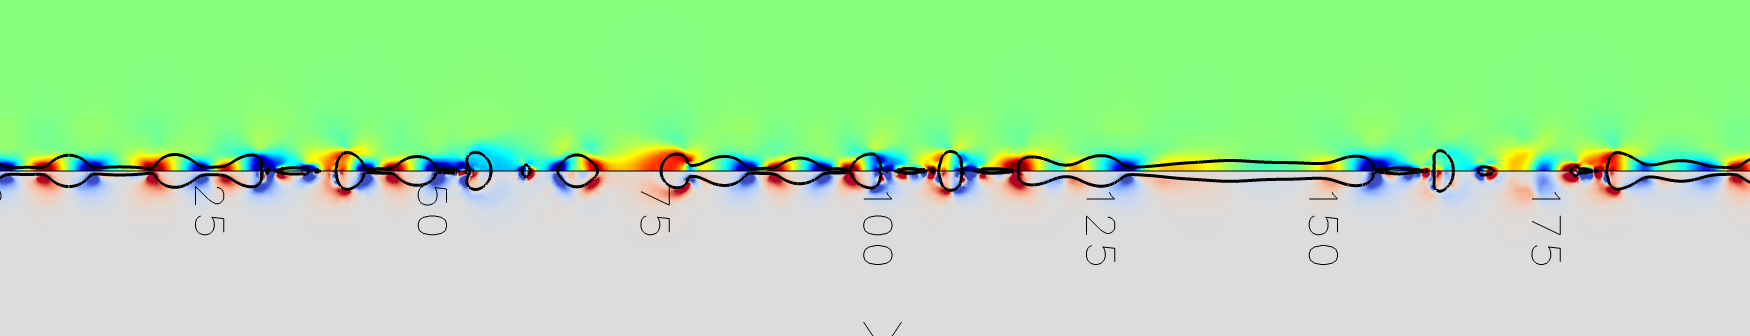

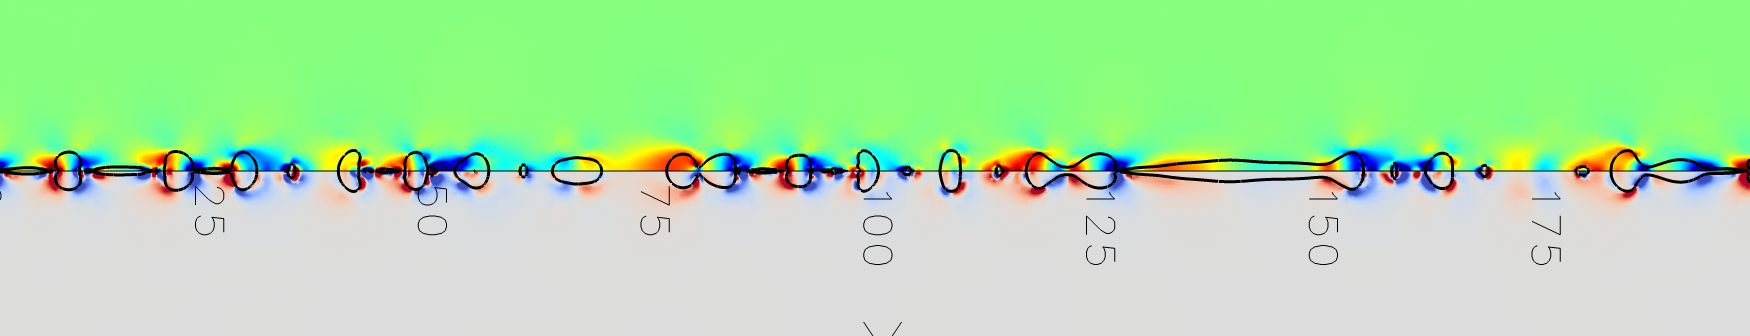

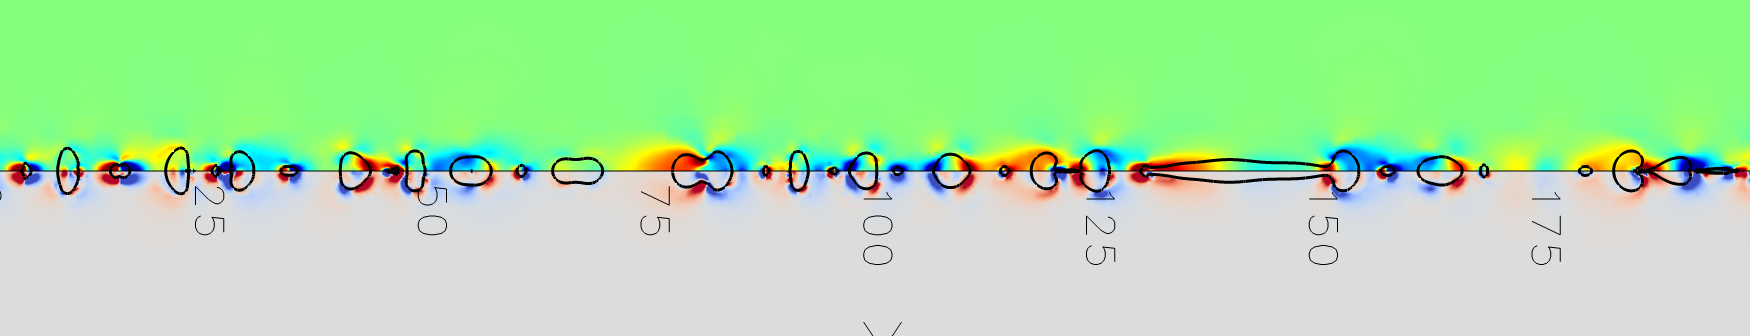

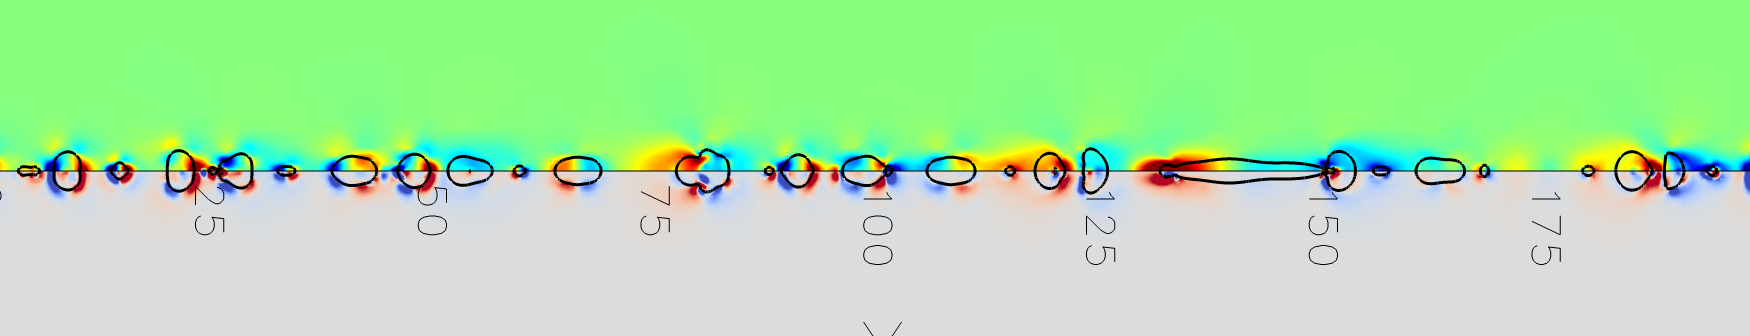

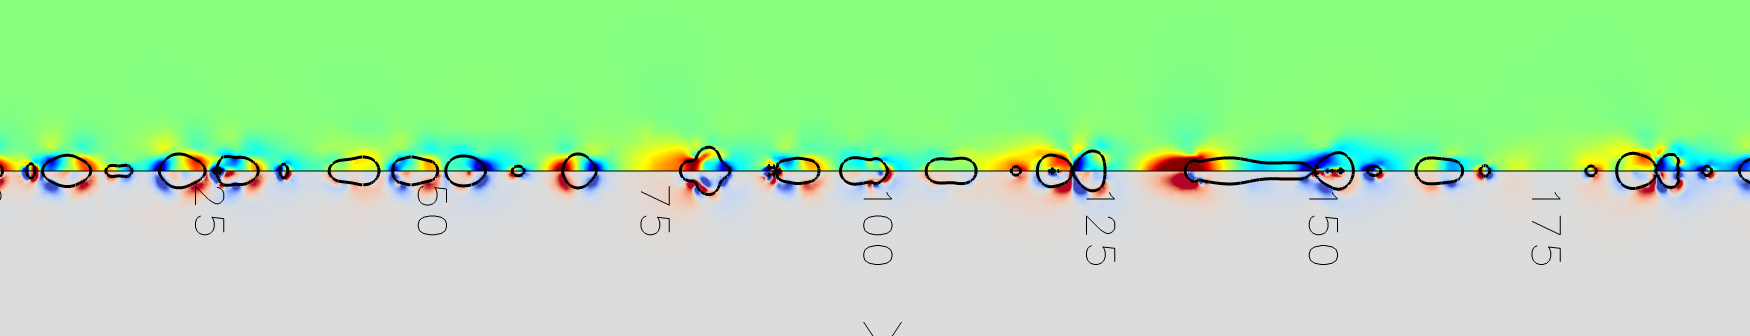

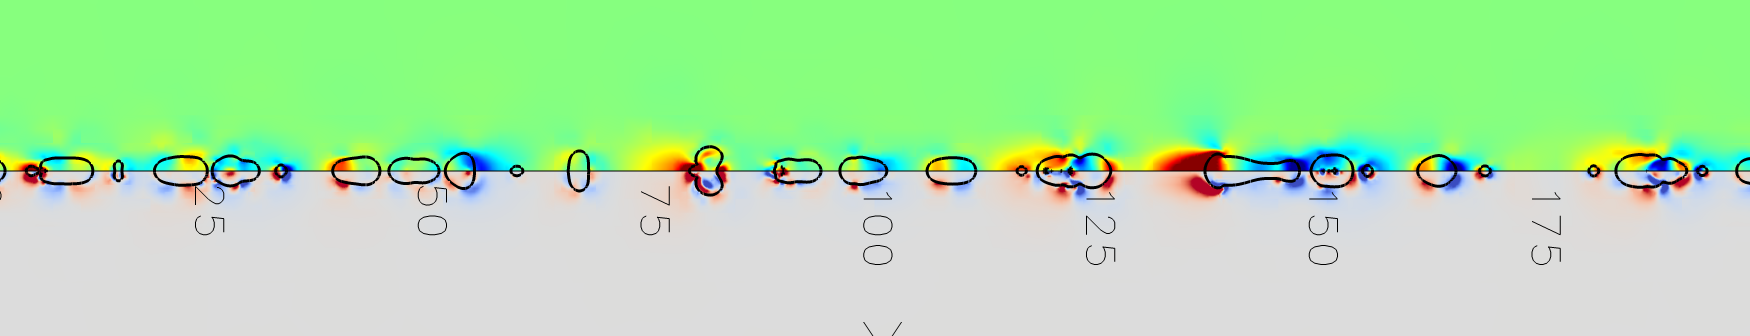

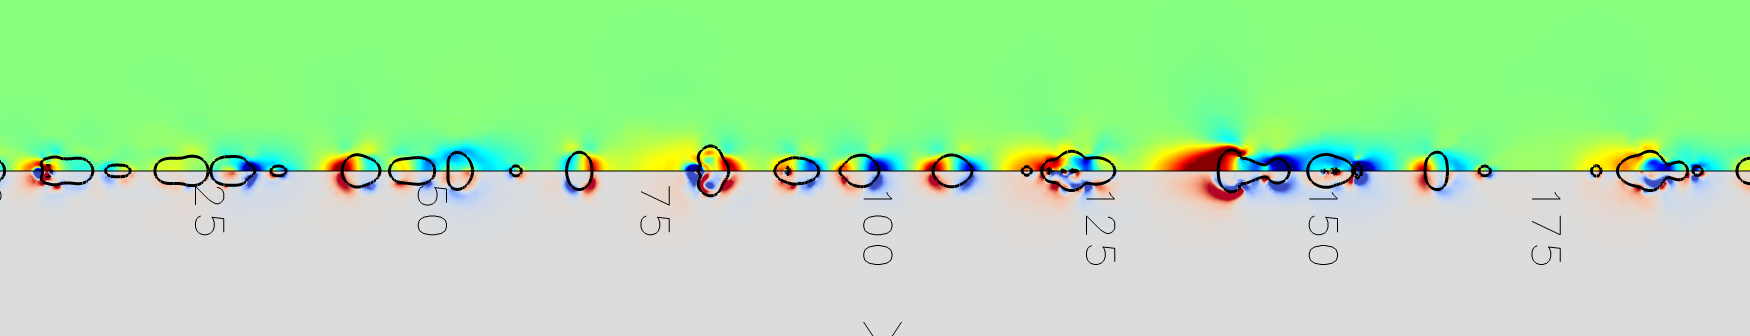

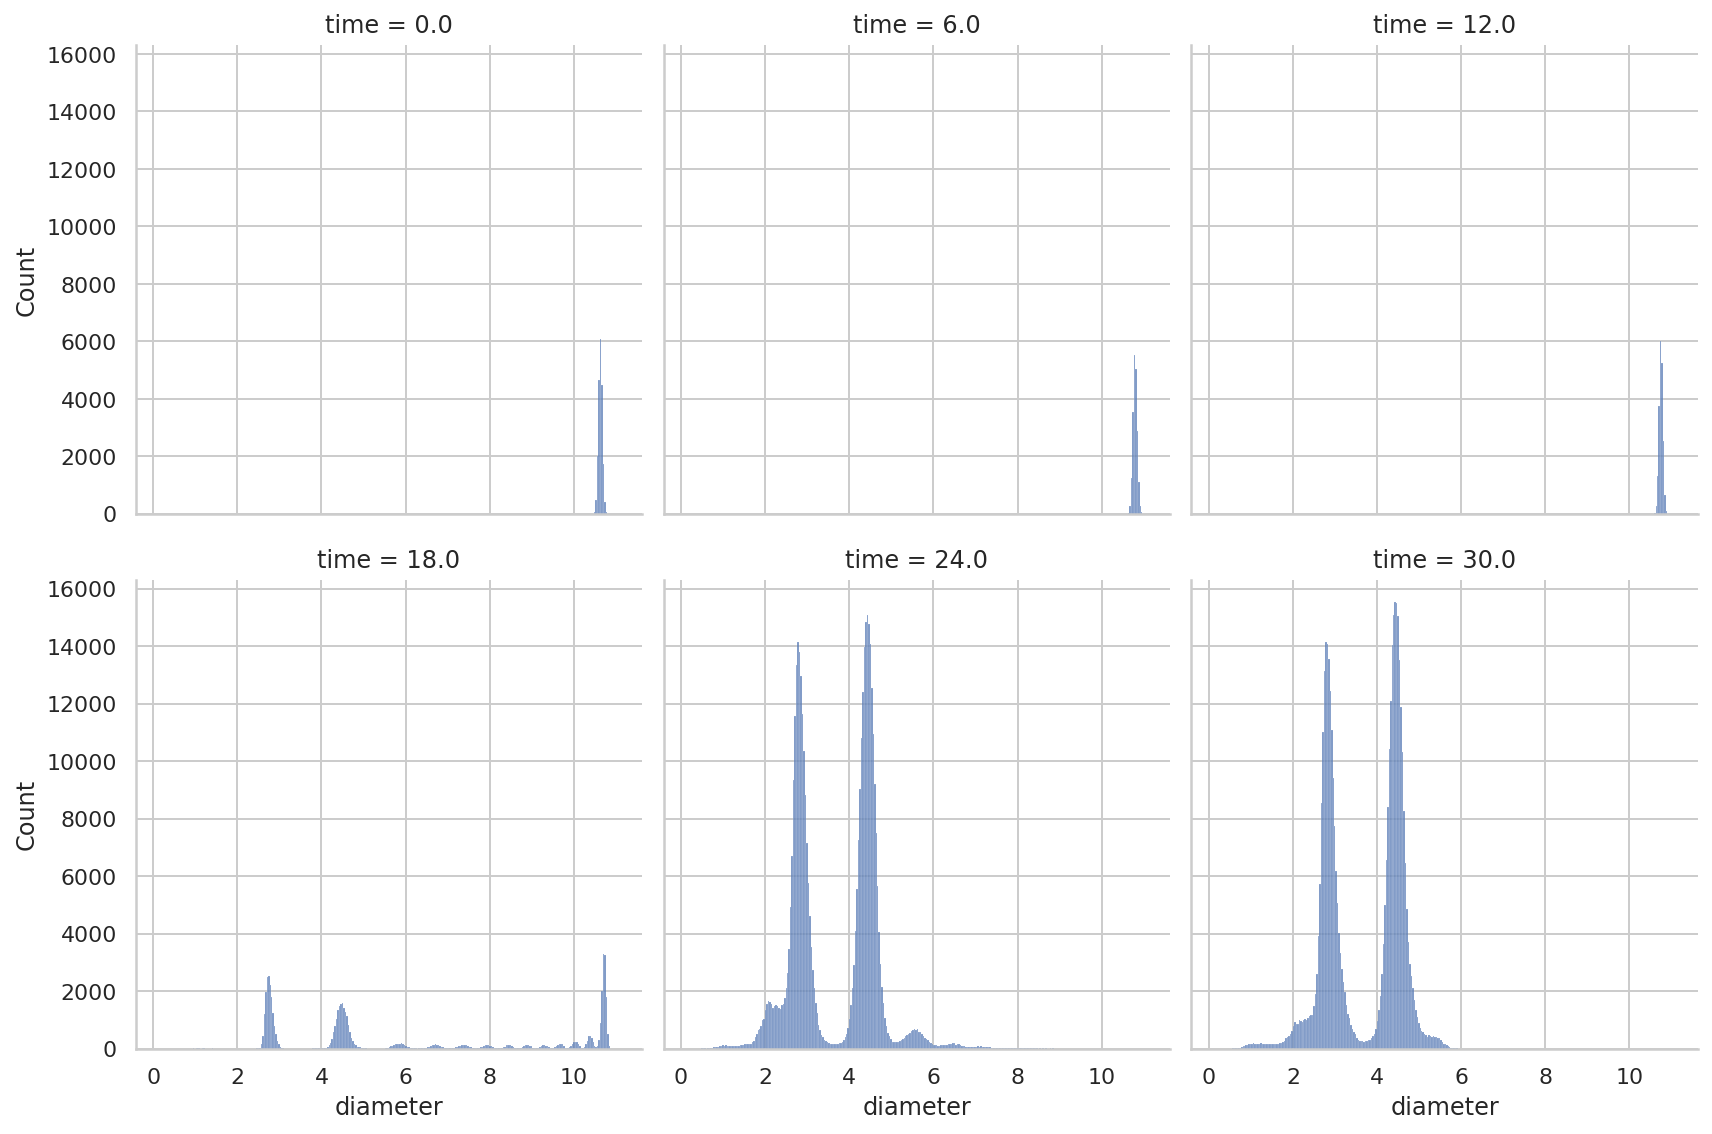

In [25]:

# The numbers at the end of the images refer to T = t/t_cap
list_1 = [
          '../d2/img-snapshot-12.png',
          '../d2/img-snapshot-13.png',
          '../d2/img-snapshot-14.png',
          '../d2/img-snapshot-15.png',
          '../d2/img-snapshot-16.png',
          '../d2/img-snapshot-17.png',   
          '../d2/img-snapshot-18.png',
         ]

# display plots from individual ligament simulations for times given in list above
for imageName in list_1:
    display(Image(filename=imageName))

# drop size distributions for different time    
sns.displot(data=d2_new, kind="hist", kde=False, x="diameter", col="time", 
            legend=True, palette="bright", height=4.0, aspect=1.0, col_wrap=3); 



### `d4` exploratory analysis

We repeat the same exercise for an individual ligament from dataset `d3`, along with the corresponding statistical size distributions. 

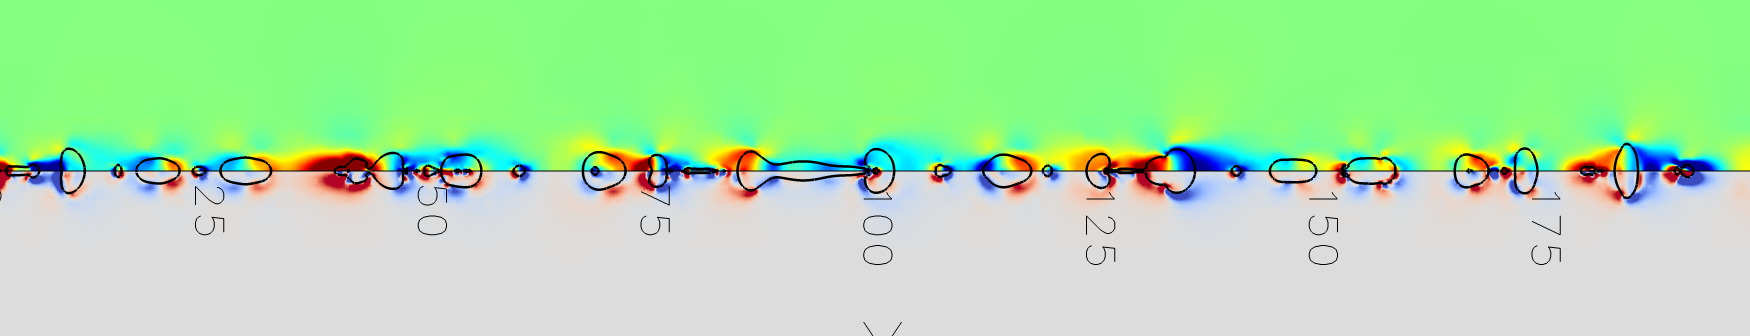

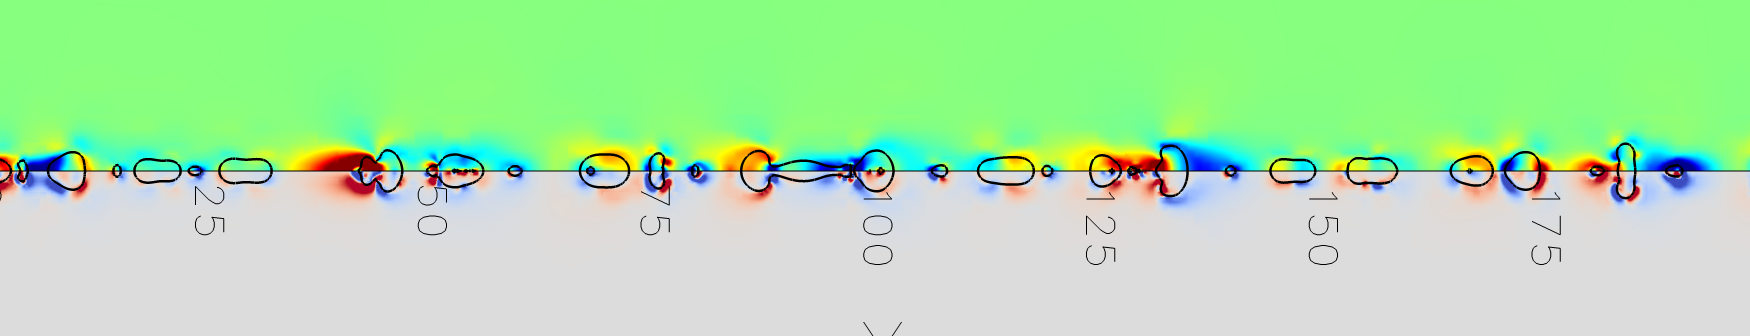

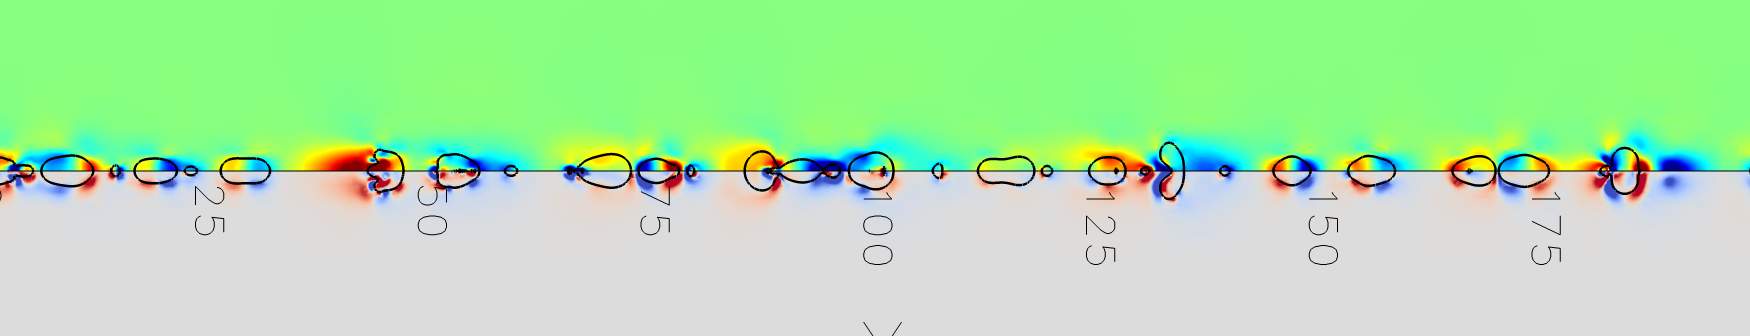

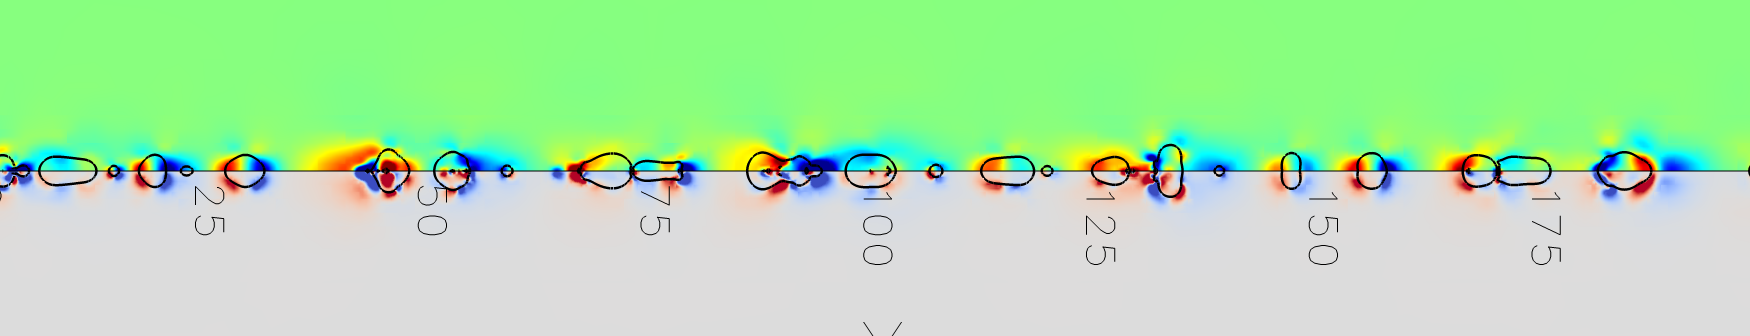

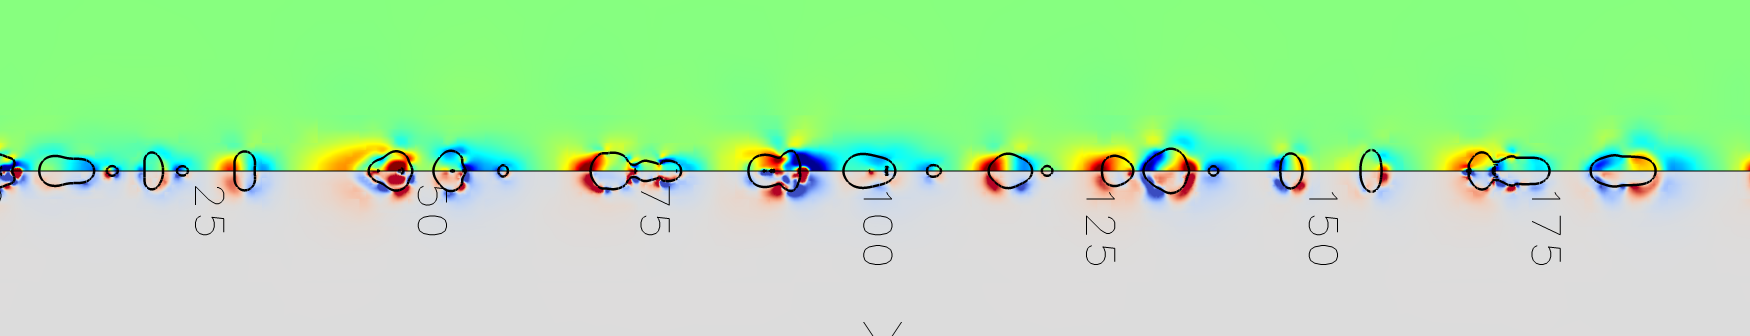

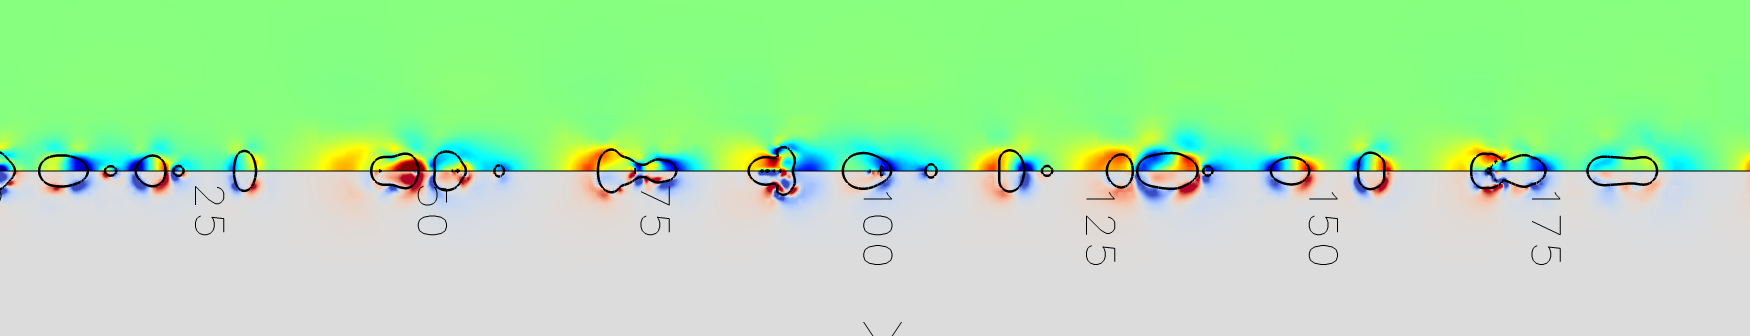

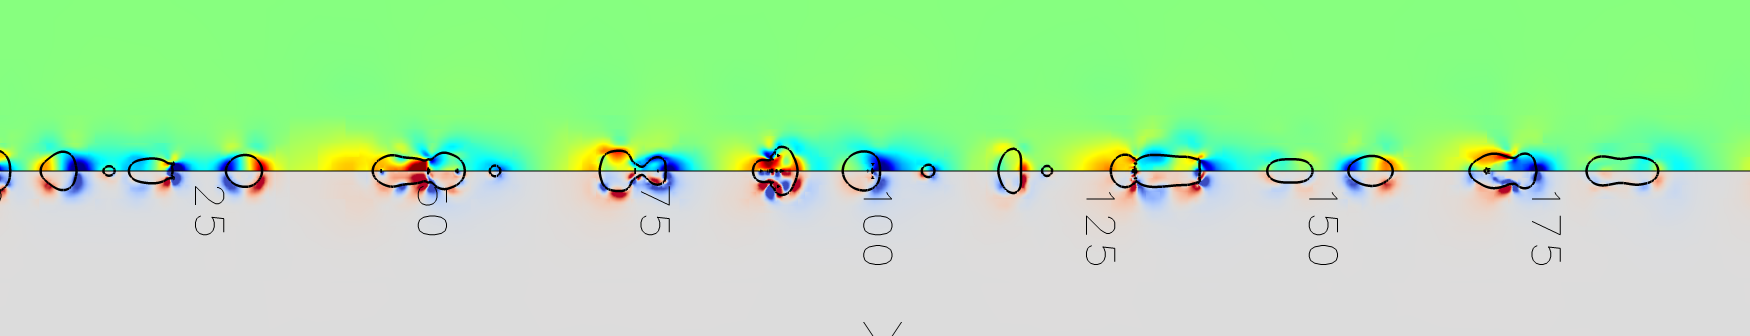

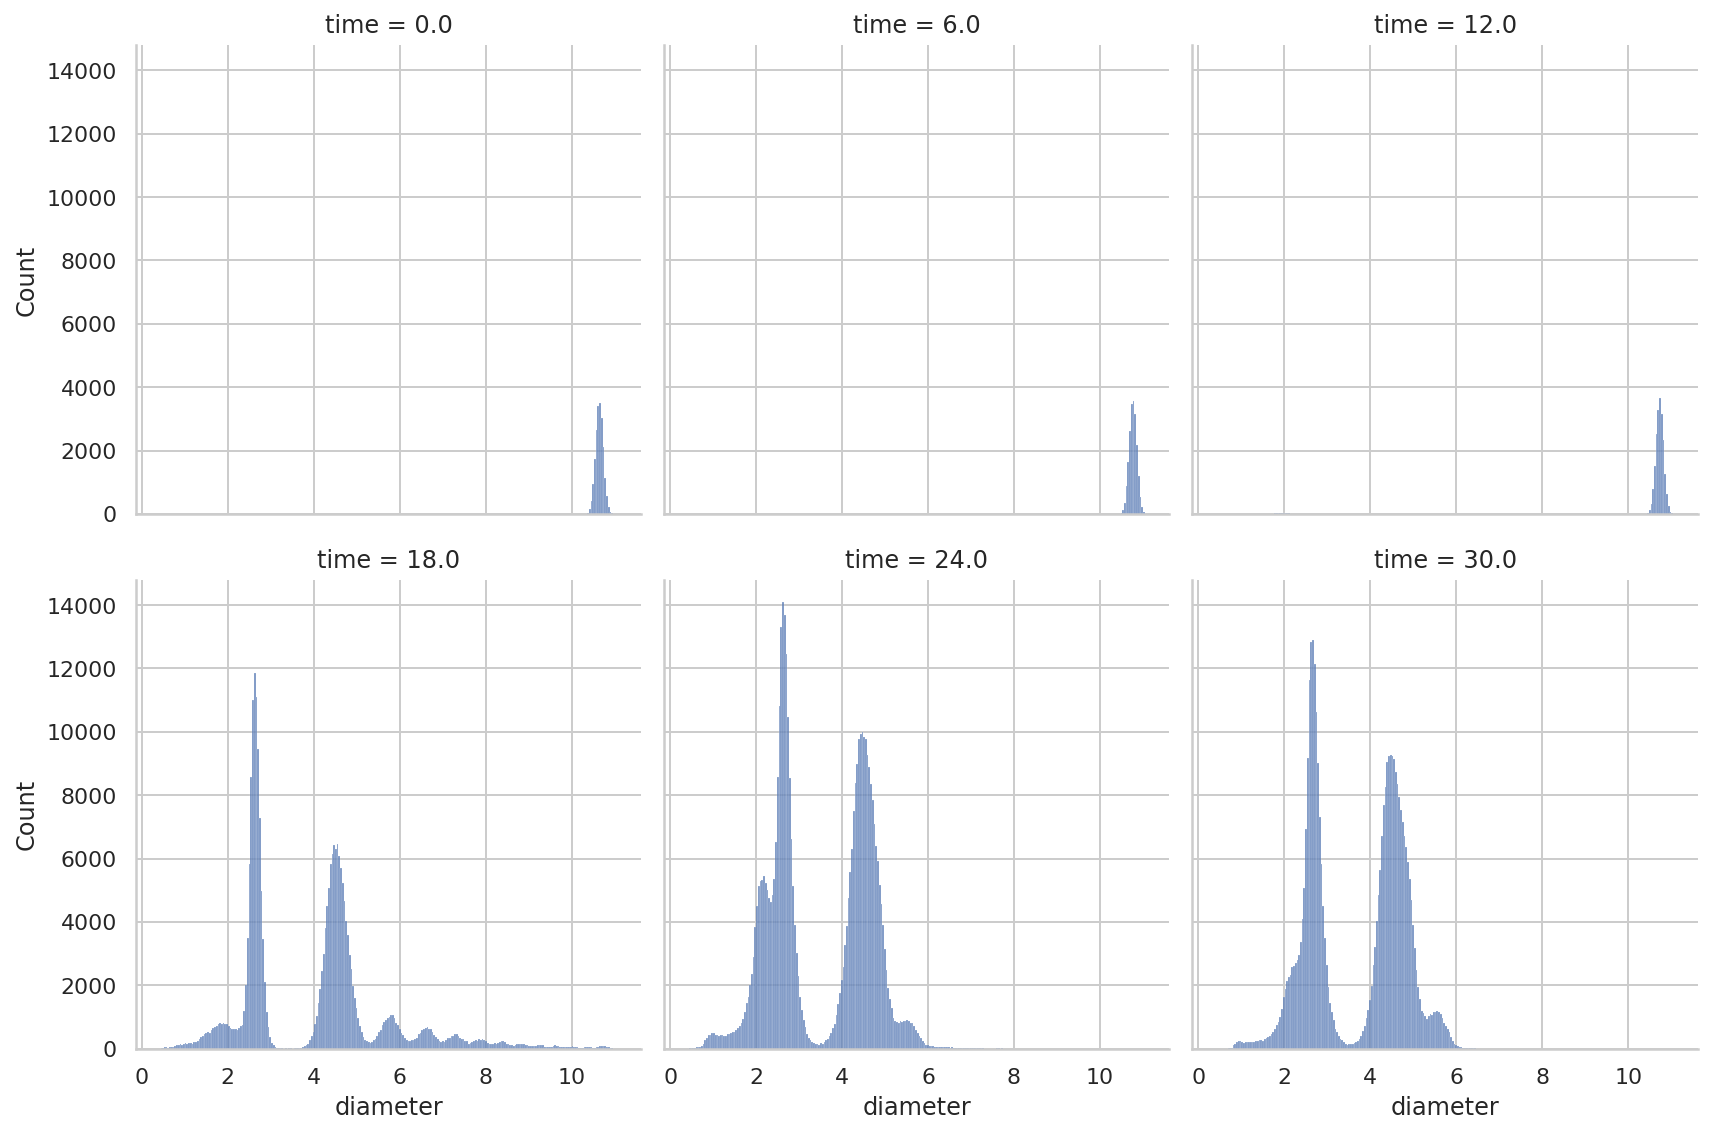

In [27]:

# image numbers refer to time T=t/t_cap
list_2 = [
          '../d4/img-snapshot-12.png',
          '../d4/img-snapshot-13.png',
          '../d4/img-snapshot-14.png',
          '../d4/img-snapshot-15.png',
          '../d4/img-snapshot-16.png',
          '../d4/img-snapshot-17.png',
          '../d4/img-snapshot-18.png',   
         ]

# display plots from individual ligament simulations for times T=12 to T=17
for imageName in list_2:
    display(Image(filename=imageName))

# plot drop size distributions at different instants of time    
sns.displot(data=d4_new, kind="hist", kde=False, x="diameter", col="time", 
            legend=True, palette="bright", height=4.0, aspect=1.0, col_wrap=3); 



## Verification of quantization effects


### Equivalent Diameters
Let us compute the values for the **equivalent diameters**, which can be simply estimated by equating the volume under our *discrete* wavelengths ($L_i $) to the volume of a drop with diameter $D_i$. Thus we get 

$$ \pi D_i^3 /6 = \pi R^2 L_i \implies D_i = (6 L_i R^2 )^{1/3} $$ 

The $i$ in the above equation refers to the discrete wave number, whose wavelength is given by $L_i = L/i$. We also rescale the the diameters with the intial width of the ligament $W$, thus giving us 

$$ D_i / W = \left(3\Lambda /2i \right)^{1/3} \,. $$

### Rayleigh-Plateau unstable wavelengths

Now, setting $i=1$, we get the maximum possible equivalent diameter, which is the case if the entire ligament collapsed into a single drop.
The shortest wavelength which is unstable with respect to Rayleigh-Plateau is given by 

$$ i \approx \Lambda/\pi \quad \implies D_\textrm{short}/W \approx 1.68 \,.$$ 

For the optimal (largest growth rate) wavelength of the Rayleigh-Plateau instability, we have 

$$ i \approx 0.7 \Lambda/\pi \quad \implies D_\textrm{rp}/W \approx 1.89 \,.$$ 

> $\Lambda = 100$ for `d2` and `d4` datasets. 

Therefore, we have several interesting values for the equivalent diameters as follows 
- $D_\textrm{max}/W \approx 5.31$ : Largest wavelength for the $\Lambda =100$ (entire ligament) .
- $D_\textrm{rp}/W \approx 1.89$ : Wavelength corresponding to optimal growth rate of Rayleigh-Plateau instability.
- $D_\textrm{short}/ W \approx 1.68$ : Shortest unstable wavelength for Rayleigh-Plateau instability.
- $D_\textrm{cut}/W \approx 1.44 $: Cut-off wavelengths set by low-pass filter for the $\Lambda =100$.


We also have to take into account the size of drops that form after a coalescence event. We assign the important values of $D/W$ computed above to some variables, and also define a function that computes the diameter of a drop formed due to coalescence of two drops. 

In [28]:
#initializing values for analysis of d1,d3 datasets

d_max = 5.31 
d_rp = 1.89
d_sh = 1.68
d_cut = 1.44 

# creating a function that computes D/W for coalescing drops (based on RP optimal)
# inputs : base (e.g. rp diameter), fractions of base d1,d2
def d_coalesce(base,d1,d2):
    factor = (d1+d2)**(1.0/3.0)
    return base*factor

### Linear scale distributions

Now we plot the histogram for dataset `d2` at $T=18$. 

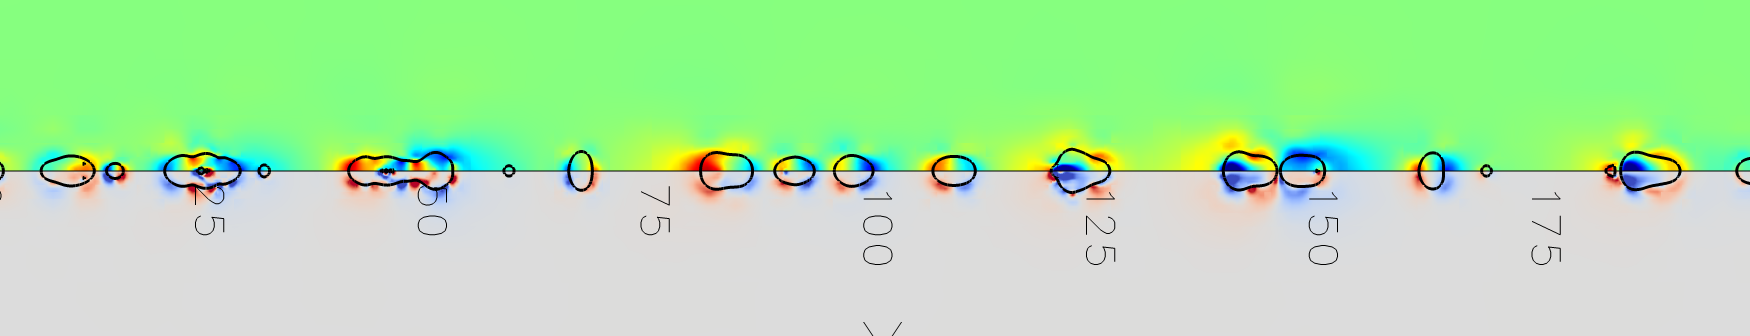

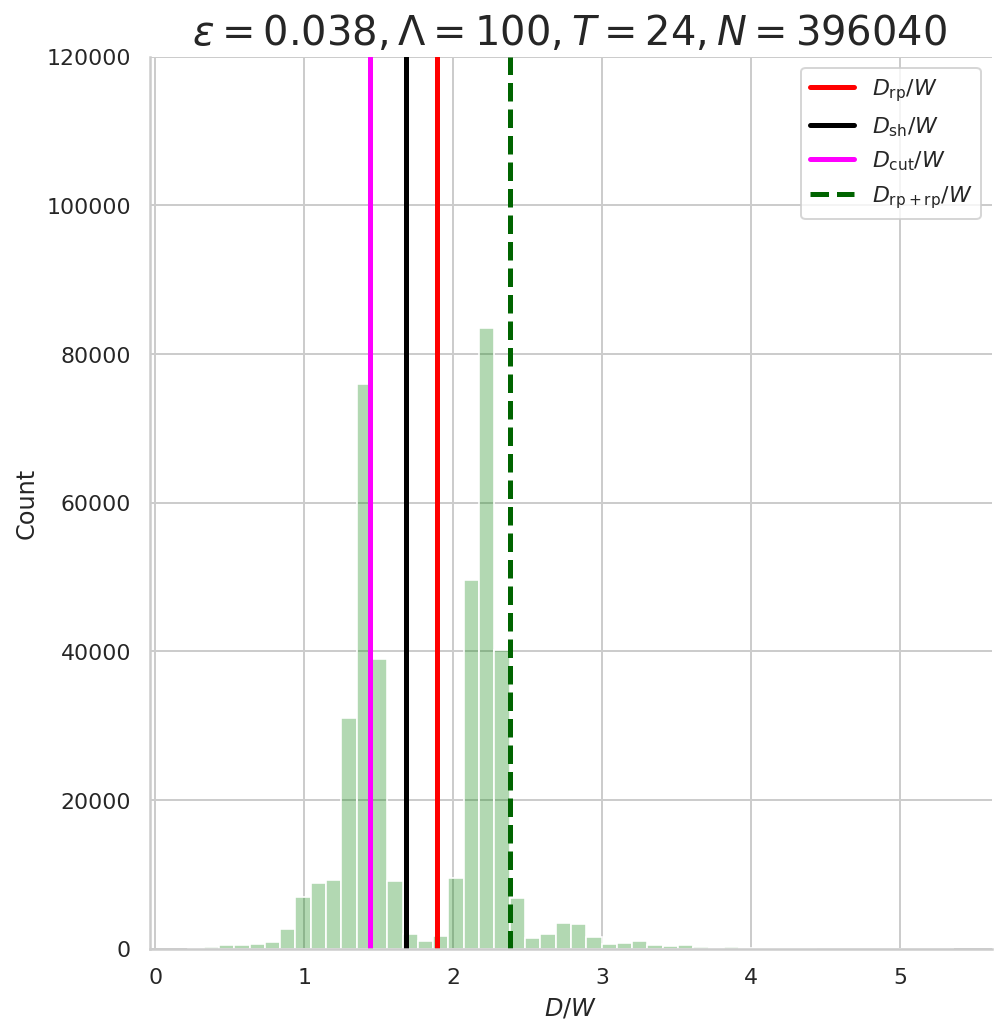

In [35]:
# histogram for d2

display(Image(filename="../d2/img-snapshot-24.png"))

time = 24
bins = 50

sns.displot(data=d2_new.diameter[(d2_new.time == time)].map(lambda p: p/2.0), kind="hist", kde=False,
            legend=True, palette="bright", height=7.0, aspect=1.0,
           alpha = 0.3 , color = 'green', bins = bins) ;

# plotting the vertical lines for d_max, d_rp, d_sh, d_cut 

#plt.axvline(x = d_max, label = r'$D_{\rm{max}}$', color='darkgreen',lw=2.5);
plt.axvline(x = d_rp, label = r'$D_{\rm{rp}}/W$', color='red', lw=2.5);
plt.axvline(x = d_sh, label = r'$D_{\rm{sh}}/W$', color='black', lw=2.5);
plt.axvline(x = d_cut, label = r'$D_{\rm{cut}}/W$', color='magenta', lw=2.5);
#plt.axvline(x = d_rp/3.0, label = r'$D_{\rm{rp}/3}/W$', color='blue', lw=2.5, linestyle='--');
#plt.xlim(right = 5.0);
plt.axvline(x = d_coalesce(d_rp,1.0,1.0), label = r'$D_{\rm{rp}+\rm{rp}}/W$', color='darkgreen', lw=2.5, linestyle='--');
#plt.axvline(x = d_coalesce(d_rp,1.0,0.33), label = r'$D_{\rm{rp}+\rm{rp}/3}/W$', color='darkred', lw=2.5, linestyle='--');
plt.title(r'$\varepsilon = 0.038, \Lambda = 100 , T=%d, N=%d$ ' %(time,d2_new.diameter[d2_new.time == time].shape[0]), fontsize=20);
plt.ylim(top=120000);
plt.xlabel(r'$D/W$')
plt.legend();


Generating the plot for dataset `d4`, which corresponds to stronger initial perturbation. 

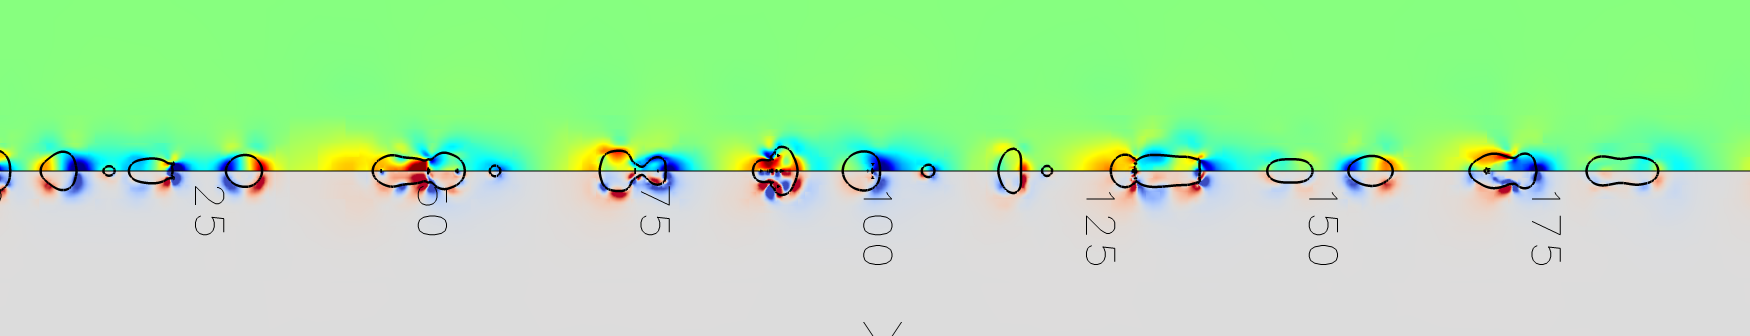

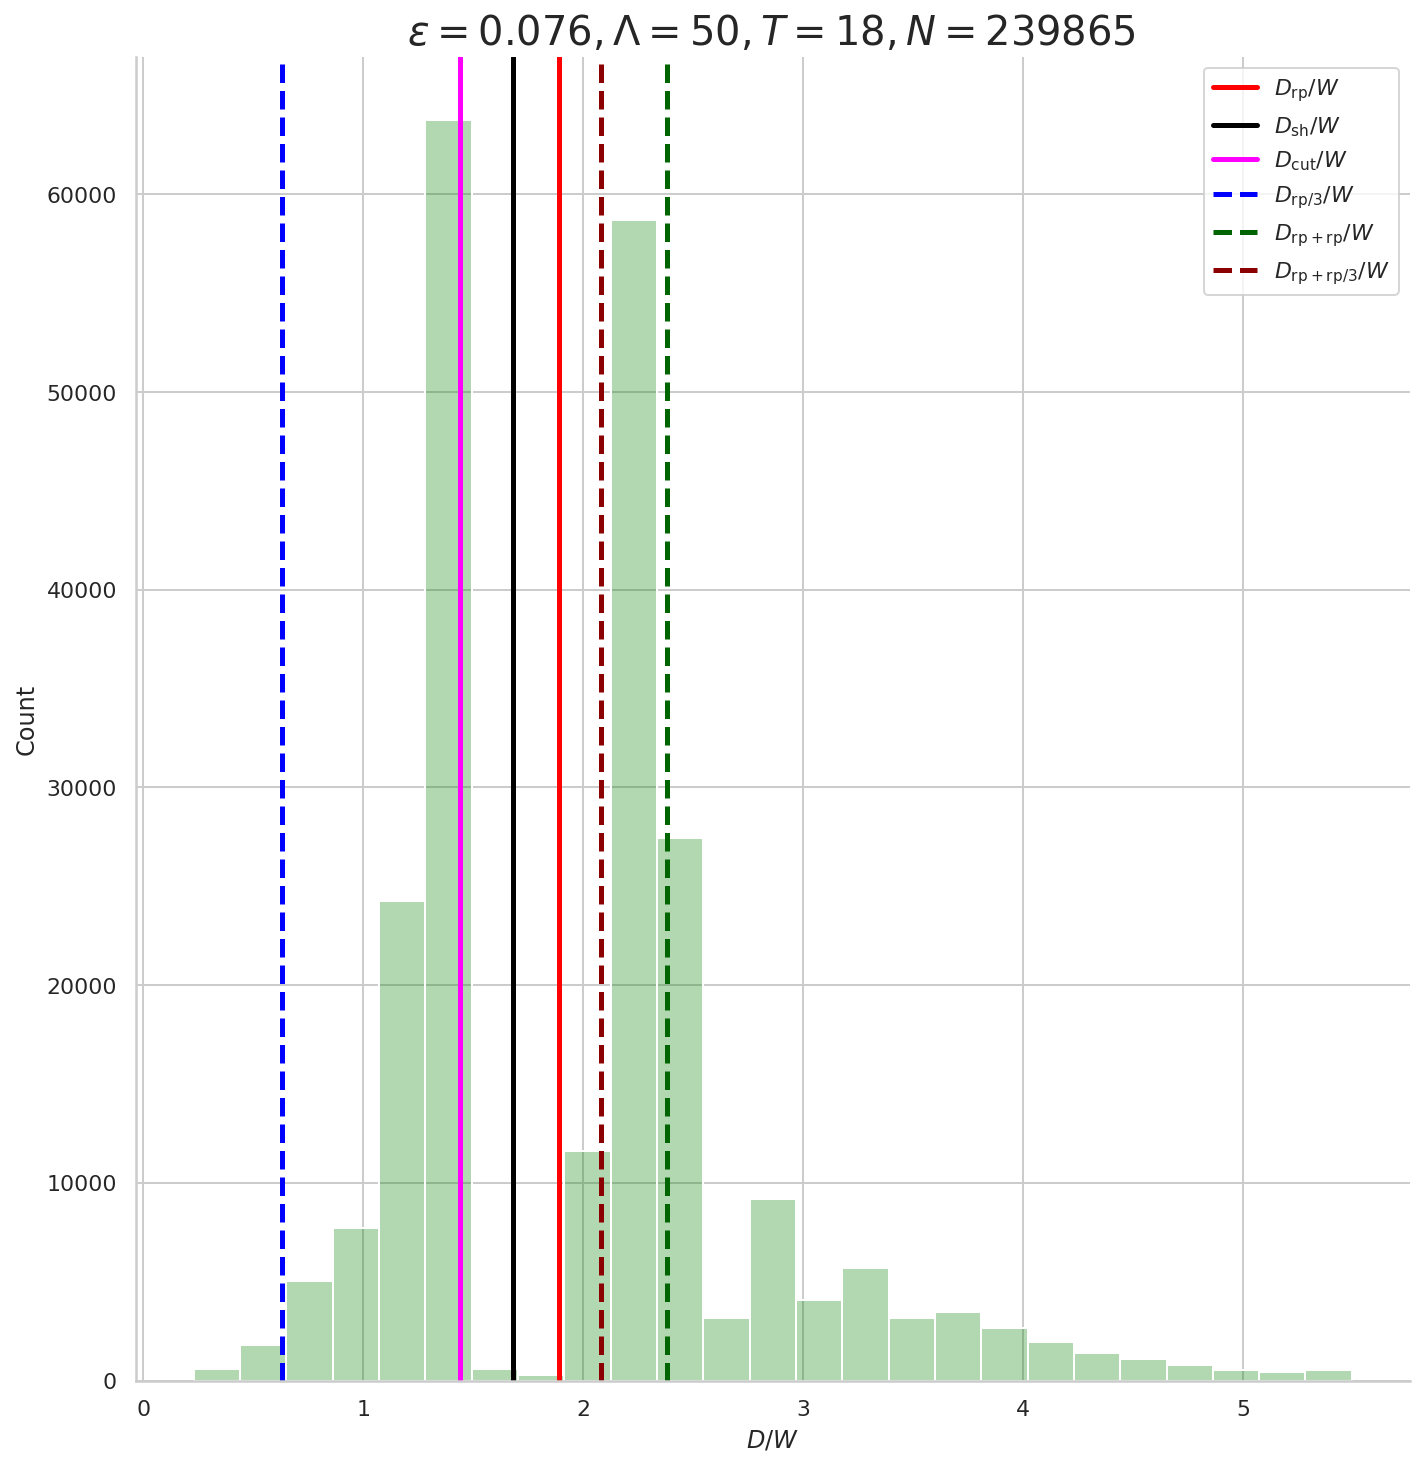

In [13]:
# histogram for d4

display(Image(filename="../d4/img-snapshot-18.png"))

time = 18
bins = 25

sns.displot(data=d4_new.diameter[(d4_new.time == time)].map(lambda p: p/2.0), kind="hist", kde=False,
            legend=True, palette="bright", height=10.0, aspect=1.0,
           alpha = 0.3 , color = 'green', bins = bins) ;

# plotting the vertical lines for d_max, d_rp, d_sh, d_cut 

#plt.axvline(x = d_max, label = r'$D_{\rm{max}}$', color='darkgreen',lw=2.5);
plt.axvline(x = d_rp, label = r'$D_{\rm{rp}}/W$', color='red', lw=2.5);
plt.axvline(x = d_sh, label = r'$D_{\rm{sh}}/W$', color='black', lw=2.5);
plt.axvline(x = d_cut, label = r'$D_{\rm{cut}}/W$', color='magenta', lw=2.5);
plt.axvline(x = d_rp/3.0, label = r'$D_{\rm{rp}/3}/W$', color='blue', lw=2.5, linestyle='--');
#plt.xlim(right = 5.0);
plt.axvline(x = d_coalesce(d_rp,1.0,1.0), label = r'$D_{\rm{rp}+\rm{rp}}/W$', color='darkgreen', lw=2.5, linestyle='--');
plt.axvline(x = d_coalesce(d_rp,1.0,0.33), label = r'$D_{\rm{rp}+\rm{rp}/3}/W$', color='darkred', lw=2.5, linestyle='--');
plt.title(r'$\varepsilon = 0.076, \Lambda = 50 , T=%d, N=%d$ ' %(time,d4_new.diameter[d4_new.time == time].shape[0]), fontsize=20);
#plt.ylim(top=80000);
plt.xlabel(r'$D/W$')
plt.legend();


### Log ordinate plots

We first create a function that computes all the equivalent diameters corresponding to all the discrete wavelenghts perturbed. 

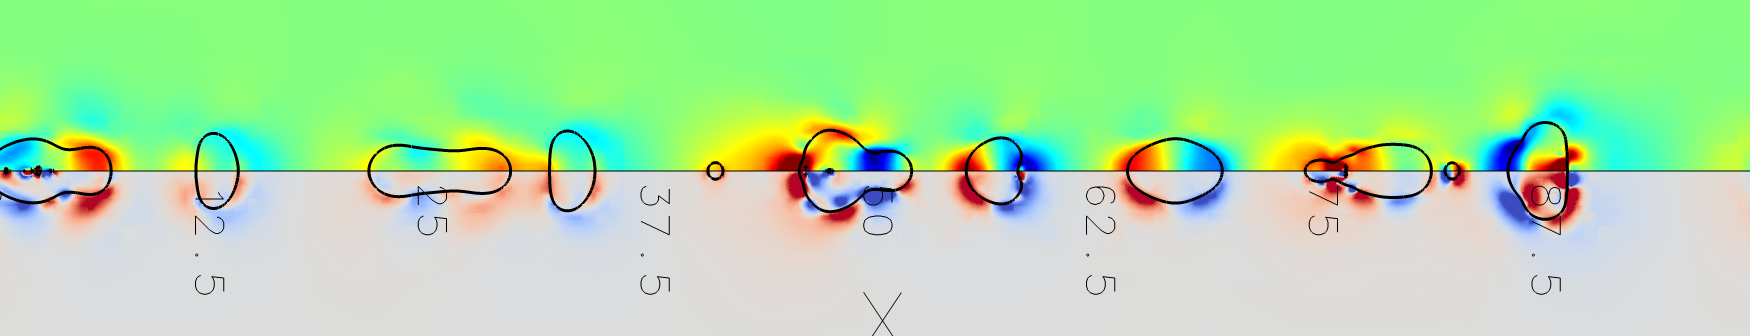

NameError: name 'd1_new' is not defined

In [14]:
# Dataset d1

display(Image(filename="../d1/img-snapshot-18.png"))

# Select time slice 
time = 18

# Set the number of bins
n_bins = 50

sns.displot(data=d1_new.diameter[(d1_new.time == time)].map(lambda p: p/2.0), kind="hist", kde=False,
            legend=True, palette="bright", height=10.0, aspect=1.0,
           alpha = 0.3 , color = 'green', bins=n_bins) ;
  
#plt.axvline(x = d_max_1, label = r'$D_{\rm{max}}$', color='darkgreen',lw=2.5);
plt.axvline(x = d_rp, label = r'$D_{\rm{rp}}/W$', color='red', lw=2.5);
plt.axvline(x = d_sh, label = r'$D_{\rm{sh}}/W$', color='black', lw=2.5);
plt.axvline(x = d_cut, label = r'$D_{\rm{cut}}/W$', color='maroon', lw=2.5);
plt.axvline(x = d_rp/3.0, label = r'$D_{\rm{rp}/3}/W$', color='blue', lw=2.5, linestyle='--');
plt.axvline(x = d_coalesce(d_rp,1.0,1.0), label = r'$D_{\rm{rp}+\rm{rp}}/W$', color='darkgreen', lw=2.5, linestyle='--');
plt.axvline(x = d_coalesce(d_rp,1.0,0.33), label = r'$D_{\rm{rp}+\rm{rp}/3}/W$', color='darkred', lw=2.5, linestyle='--');
plt.title(r'$\varepsilon = 0.038, \Lambda = 50 , T=%d, N=%d$ ' %(time,d1_new.diameter[d1_new.time == time].shape[0]), fontsize=20);
plt.legend(loc='best');
plt.yscale("log");
plt.ylim(top=1e6);
#plt.xlim(right = 5.0);
plt.xlabel(r'$D/W$');

In [ ]:
# Dataset d3

display(Image(filename="../d3/img-snapshot-12.png"))

# Select time slice 
time = 12

# Set the number of bins
n_bins = 50

sns.displot(data=d3_new.diameter[(d3_new.time == time)].map(lambda p: p/2.0), kind="hist", kde=False,
            legend=True, palette="bright", height=10.0, aspect=1.0,
           alpha = 0.3 , color = 'green', bins=n_bins) ;
  
#plt.axvline(x = d_max_1, label = r'$D_{\rm{max}}$', color='darkgreen',lw=2.5);
plt.axvline(x = d_rp, label = r'$D_{\rm{rp}}/W$', color='red', lw=2.5);
plt.axvline(x = d_sh, label = r'$D_{\rm{sh}}/W$', color='black', lw=2.5);
plt.axvline(x = d_cut, label = r'$D_{\rm{cut}}/W$', color='maroon', lw=2.5);
plt.axvline(x = d_rp/3.0, label = r'$D_{\rm{rp}/3}/W$', color='blue', lw=2.5, linestyle='--');
plt.axvline(x = d_coalesce(d_rp,1.0,1.0), label = r'$D_{\rm{rp}+\rm{rp}}/W$', color='darkgreen', lw=2.5, linestyle='--');
plt.axvline(x = d_coalesce(d_rp,1.0,0.33), label = r'$D_{\rm{rp}+\rm{rp}/3}/W$', color='darkred', lw=2.5, linestyle='--');
plt.title(r'$\varepsilon = 0.076, \Lambda = 50 , T=%d, N=%d$ ' %(time,d3_new.diameter[d3_new.time == time].shape[0]), fontsize=20);
plt.legend(loc='best');
plt.yscale("log");
plt.ylim(top=1e6);
#plt.xlim(right = 5.0);
plt.xlabel(r'$D/W$');

## Key Findings 

- Two types of main peaks are observed in the distribution corresponding to -  
 1. Linear growth (exponential) of the **Rayleigh-Plateau** optimal wavelength.
 2. Non-linear effects leading to **satellite** drops, which are roughly smaller (volume or mass) by a factor of 10.  



- The secondary peaks are primarily due to **coalescence of different combinations** of the two *primary* drop sizes.  